In [164]:
from astropy.io import ascii
from astropy.table import vstack,Table,Column
import matplotlib.pyplot as plt
import numpy as np

def read_lc(number):
    path='../results/91bg_1/91bg_1_SN0'+str(number)+'.DAT'
    file=open(path)
    h_start=0
    d_start1=0
    d_end1=0
    d_start2=0
    d_end2=0
    section_2=False
    header=True
    DETECT=False
    for line in file:  # This for loop can find the header_start, data_start and data_end 
        if header==True:
            if line[:8]=='SIM_DLMU':
                dismod=float(line.split()[1])
            if line[:7]=='VARLIST':
                d_start1=h_start+1
                d_end1=d_start1
                header=False
            elif line[:1] not in ('#'+'\n'+' '):
                h_start=h_start+1
        if line[:4]=='OBS:':
            if section_2==False:
                d_end1=d_end1+1
            elif section_2==True:
                d_end2=d_end2+1
        if line[:9]=='DETECTION':
            DETECT=True
            d_start2=d_end1+1
            d_end2=d_start2
            section_2=True
        if line[:11]=='SIM_PEAKMAG':
            peak=line.split()[1:6]
    file.close()
    if DETECT==True:
        table1=ascii.read(path,guess=False,delimiter=' ',header_start=h_start,data_start=d_start1,data_end=d_end1)
        table2=ascii.read(path,guess=False,delimiter=' ',header_start=h_start,data_start=d_start2,data_end=d_end2)
        table=vstack([table1,table2])  
    else:
        table=ascii.read(path,guess=False,delimiter=' ',header_start=h_start,data_start=d_start1,data_end=d_end1)
    u=(table['FLT']=='u')   
    uband=table[u].copy()
    uband.sort('SIM_MAGOBS')
    date=Column(name='Date',data=list(table['MJD']-uband['MJD'][0]))
    Mag=Column(name='Abs_Mag',data=list(table['SIM_MAGOBS']-dismod))
    table.add_column(date)  # add two columns to the table which are date and absolute Mag
    table.add_column(Mag)
    table.meta['peakmag']=peak
    return table


In [165]:
def col(b):
    bands='ugriz'  
    color='ygrkm'  #color(literally) for each band
    for i in range(len(bands)):
        if b==bands[i]:
            return color[i]
    
def col_fill(b):
    bands='ugriz'
    color=[(150/255, 233/255, 249/255),(217/255, 135/255, 255/255),(157/255, 161/255, 249/255),(190/255, 194/255, 249/255),(166/255, 1, 155/255)]
    for i in range(len(bands)):
        if b==bands[i]:
            return color[i]
    
def plot_lc(data,bands,ax):
    for b in 'ugriz':
        if b in bands:
            mask0=(data['FLT']==b)  # mask to select filter band 
            mask1=(data['SIM_MAGOBS'][mask0]<30)  # discard negative flux data
            x=data['Date'][mask0][mask1]
            y=data['Abs_Mag'][mask0][mask1]
            ax.plot(x,y,color=col(b),label=b,linewidth=0.8)


def scatter_lc(data,bands,ax):
    for b in 'ugriz':
        if b in bands:
            mask0=(data['FLT']==b)  # mask to select filter band 
            mask1=(data['SIM_MAGOBS'][mask0]<30)  # discard negative flux data
            x=data['Date'][mask0][mask1]
            y=data['Abs_Mag'][mask0][mask1]
            ax.scatter(x,y,color=col(b),label=b,s=2)


In [166]:
def average_lc(data,band):
    m0=(data['FLT']==band)  # mask to select filter band 
    m1=(data['SIM_MAGOBS'][m0]<30)  # discard negative flux data
    day_r=np.arange(round(data['Date'][m0][m1][0]),round(data['Date'][m0][m1][-1]),1)
    date=np.zeros(len(day_r))
    count=np.zeros(len(day_r))
    Mag_mean=np.zeros(len(day_r))
    Mag_std=np.zeros(len(day_r))
    for i,n in enumerate(day_r):
        M=list()
        D=list()
        for j,d in enumerate(data['Date'][m0][m1]):
            if round(d)==n:
                count[i]+=1
                M.append(data['Abs_Mag'][m0][m1][j])
                D.append(data['Date'][m0][m1][j])
            if round(d)>n:
                if count[i]==0:
                    date[i]=n
                    break
                date[i]=np.mean(D)
                Mag_mean[i]=np.mean(M)
                Mag_std[i]=np.std(M)
                break
    dat_avg=Table([date,count,Mag_mean,Mag_std],names=['Date','Count','Mag_mean','Mag_std'])
    return dat_avg


# Scatter plot of all generated light curves 

Text(0.5,1.05,'Light curve average & error region')

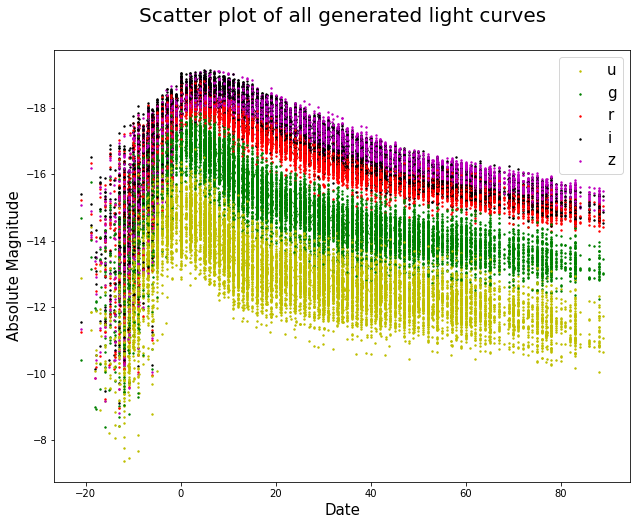

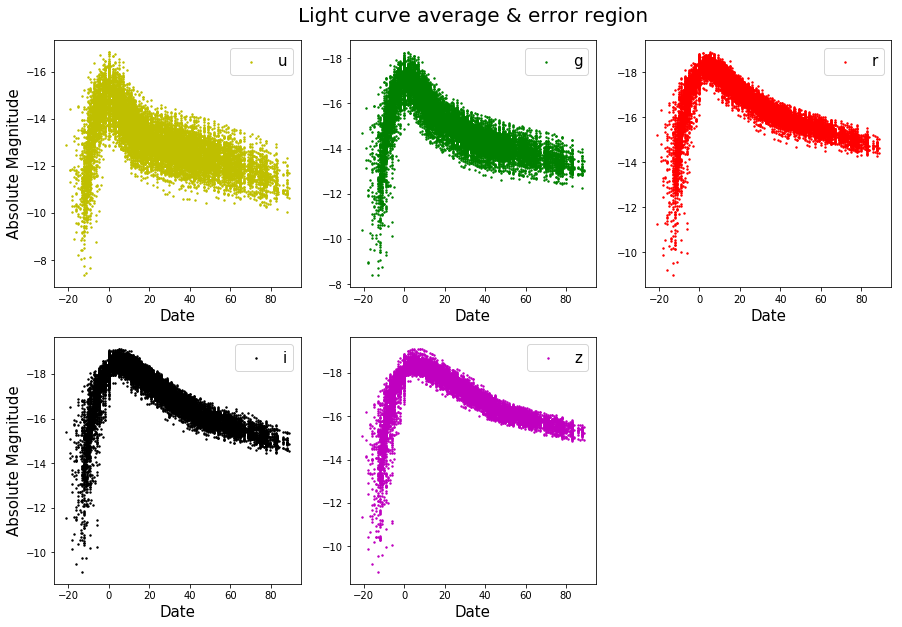

In [156]:
fig=plt.figure(figsize=(8,6))
ax=fig.add_axes((0,0,1,1))
lc=range(0,1000)
for i in lc:
    data0=read_lc(50000+i+1)
    scatter_lc(data0,'ugriz',ax)
    if i==lc[0]:
        ax.legend(fontsize=15)
        data=data0
    else:
        data=vstack([data,data0])

ax.invert_yaxis()
ax.set_ylabel('Absolute Magnitude',fontsize=15)
ax.set_xlabel('Date',fontsize=15)
ax.set_title('Scatter plot of all generated light curves',fontsize=20,fontweight='light',y=1.05)
data.sort(['Date','FLT'])

fig2=plt.figure(figsize=(15,10))
ax=list(range(len('ugriz')))
for i in range(len('ugriz')):
    ax[i]=plt.subplot(231+i)

for i in lc:
    data0=read_lc(50000+i+1)
    for j,b in enumerate('ugriz'):
        scatter_lc(data0,b,ax[j])
        if i==lc[0]:
            ax[j].legend(fontsize=15)
        if i==lc[-1]:
            ax[j].invert_yaxis()
            ax[j].set_xlabel('Date',fontsize=15)
            if j in [0,3]:
                ax[j].set_ylabel('Absolute Magnitude',fontsize=15)
ax[1].set_title('Light curve average & error region',fontsize=20,fontweight='light',y=1.05)

# Average light curves & error region

Text(0.5,1.05,'Light curve average & error region')

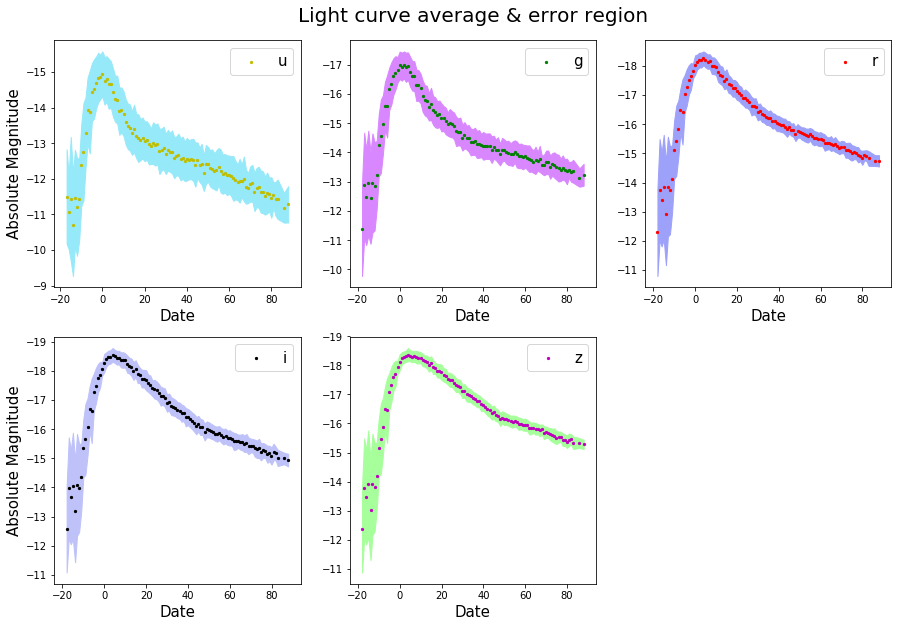

In [157]:
def plot_lc_avg(dat,band,ax):
    mask=dat['Count']>5
    x=dat['Date'][mask]
    y=dat['Mag_mean'][mask]
    std=dat['Mag_std'][mask]
    #ax.scatter(x,y+std,c='k',label=band,linewidth=1,s=5)
    ax.fill_between(x,y-std,y+std,color=col_fill(band),linewidth=1)
    ax.scatter(x,y,c=col(band),label=band,linewidth=1,s=5)
    #ax.scatter(x,y-std,c='k',label=band,linewidth=1,s=5)

fig=plt.figure(figsize=(15,10))
ax=list(range(len('ugriz')))
for i in range(len('ugriz')):
    ax[i]=plt.subplot(231+i)
for i,b in enumerate('ugriz'):
    avg=average_lc(data,b)
    plot_lc_avg(avg,b,ax[i])
    ax[i].invert_yaxis()
    ax[i].legend(fontsize=15)
    ax[i].set_xlabel('Date',fontsize=15)
    if i in [0,3]:
        ax[i].set_ylabel('Absolute Magnitude',fontsize=15)
ax[1].set_title('Light curve average & error region',fontsize=20,fontweight='light',y=1.05)

# Color-color relation for all simulated targets

In [170]:
lc=range(0,1000)
bands=list(range(5))
for i in lc:
    data0=read_lc(50000+i+1)
    for j,b in enumerate('ugriz'):
        if i==lc[0]:
            bands[j]=list()
        bands[j].append(float(data0.meta['peakmag'][j]))
peakmag=Table([bands[0],bands[1],bands[2],bands[3],bands[4]],names=['u','g','r','i','z'])

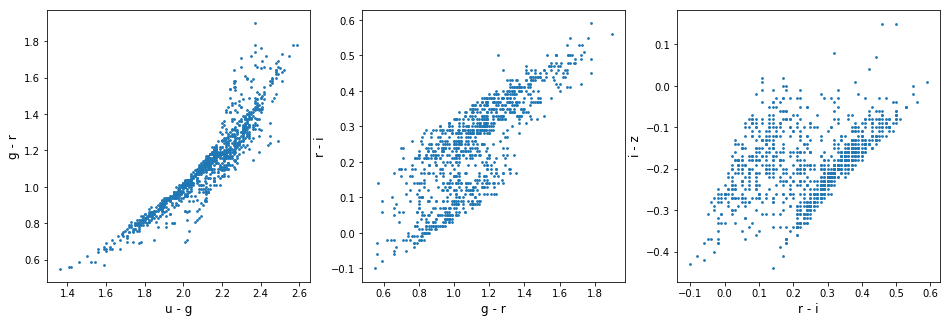

In [171]:
fig=plt.figure(figsize=(16,5))
ax=list(range(3))
for i in range(3):
    ax[i]=plt.subplot(131+i)
def cc_plot(table):
    bands='ugriz'
    for i in range(3):
        x=table[bands[i]]-table[bands[i+1]]
        y=table[bands[i+1]]-table[bands[i+2]]
        ax[i].scatter(x,y,s=3)
        ax[i].set_xlabel(bands[i]+' - '+bands[i+1],fontsize=12,fontweight='light')
        ax[i].set_ylabel(bands[i+1]+' - '+bands[i+2],fontsize=12,fontweight='light')

cc_plot(peakmag)

# Average color-color diagram over time

In [159]:
avg=list(range(5))
m=list(range(5))
for i,b in enumerate('ugriz'):
    avg[i]=average_lc(data,b)
    m[i]=avg[i]['Count']>5
cc_table=Table([avg[0]['Date'][m[0]],avg[0]['Mag_mean'][m[0]],avg[1]['Mag_mean'][m[0]],avg[2]['Mag_mean'][m[0]],avg[3]['Mag_mean'][m[0]],avg[4]['Mag_mean'][m[0]]],names=['Date','u','g','r','i','z'])


In [150]:
fig=plt.figure(figsize=(16,16))
ax=list(range(3))
for i in range(3):
    ax[i]=plt.subplot(221+i)
mask=list(range(len(cc_table)))
for i in range(len(mask)):
    mask[i]=False
    if np.mod(i,4)==0:   #This mask controls how many points to plot
        mask[i]=True
    if round(cc_table['Date'][i])==0:
        mask[i]=True

def cct_plot(table):
    bands='ugriz'
    for i in range(3):
        x=table[bands[i]][mask]-table[bands[i+1]][mask]
        y=table[bands[i+1]][mask]-table[bands[i+2]][mask]
        ax[i].plot(x,y,'-')
        ax[i].scatter(x,y,s=6)
        date=table['Date'][mask]
        ax[i].set_xlabel(bands[i]+' - '+bands[i+1],fontsize=15,fontweight='light')
        ax[i].set_ylabel(bands[i+1]+' - '+bands[i+2],fontsize=15,fontweight='light')
        for j in range(len(x)):
            if np.mod(j,1)==0 or round(date[j])==0:
                ax[i].text(x[j],y[j],str(round(date[j]))[:-2])

cct_plot(cc_table)

# 2D Histogram of stretch vs color

In [160]:
path='../results/91bg_1.DUMP'
x1_c=ascii.read(path,guess=False,delimiter=' ',header_start=1,data_start=2)

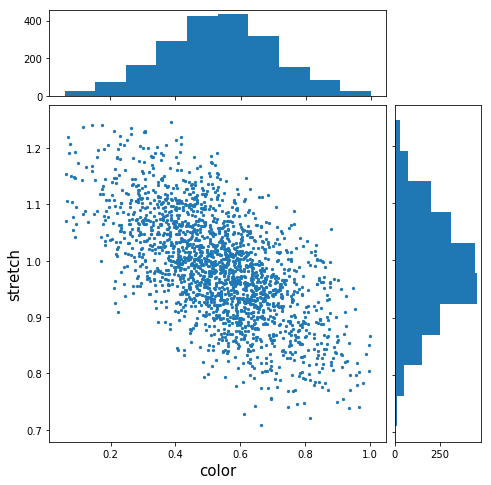

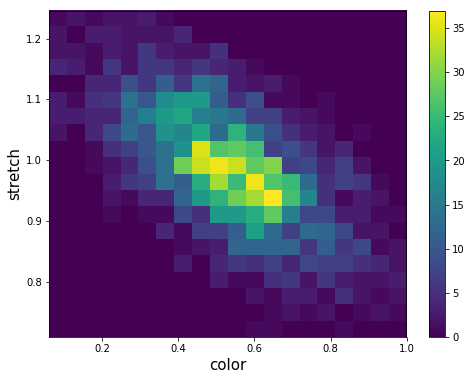

In [161]:
fig=plt.figure(figsize=(6,6))
ax=fig.add_axes((0,0,0.78,0.78))
ax1=fig.add_axes((0,0.8,0.78,0.2))
ax2=fig.add_axes((0.8,0,0.2,0.78))
ax.scatter(x1_c['color'],x1_c['stretch'],s=5)
ax1.hist(x1_c['color'])
ax2.hist(x1_c['stretch'],orientation='horizontal')
ax1.set_xticklabels([])
ax2.set_yticklabels([])
ax.set_xlabel('color',fontsize=15,fontweight='light')
ax.set_ylabel('stretch',fontsize=15,fontweight='light')

fig2=plt.figure(figsize=(8,6))
plt.hist2d(x1_c['color'],x1_c['stretch'],[20,20])
plt.xlabel('color',fontsize=15,fontweight='light')
plt.ylabel('stretch',fontsize=15,fontweight='light')
plt.colorbar()